In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats
import math
from hmmlearn import hmm

plt.rcParams["figure.figsize"] = (12, 9) 

In [2]:
# load in data, convert Date to datetime type
spy = pd.read_csv("../Data/spy_processed.csv")
spy["Date"] = pd.to_datetime(spy["Date"])

In [3]:
# log transform some columns
spy["volume_dev"] = np.log(spy["volume_dev"])
spy["range"] = np.log(spy["range"])
spy["var"] = np.log(spy["var"])

In [4]:
# take relevent columns
X = spy[["Date","Adj Close","ret","volume_dev","range","var"]]

In [5]:
# create HMM
class HMM:
    def __init__(self,n_comp):
        self.hmm = hmm.GaussianHMM(n_components=n_comp, covariance_type="full",n_iter=1000)
        self.n_comp = n_comp
        self.feature_names = ["ret","volume_dev","range","var"]
        self.data = X[self.feature_names]
        self.start = 0
        self.end = X.shape[0]
        self.dates = X["Date"]
        self.adj_close = X["Adj Close"]
        self.states = 0
    
    # fit the HMM to a range of indices (start, end)
    def fit_range(self, start, end):
        self.hmm = hmm.GaussianHMM(n_components=self.n_comp, covariance_type="full",n_iter=1000)
        self.start = start
        self.end = end
        self.hmm.fit(self.data.iloc[start:end,:])
        self.states = self.hmm.predict(self.data.iloc[start:end,:])
    
    # predict the next close and 95% CI AFTER running fit_range
    def predict_next_close(self):
        means = self.hmm.means_[:,0]
        var = np.exp(self.hmm.means_[:,3])
        transmat = self.hmm.transmat_.transpose()
        probs = self.hmm.predict_proba(self.data.iloc[self.start:self.end,:])[self.end-self.start-1,:]
        probs = np.matmul(transmat,probs) # get a priori prob for next day
        # estimate return and its 95% CI for tomorrow
        pred_ret = np.dot(means, probs)
        pred_sd = np.sqrt(np.dot(var, probs))
        left_ret = pred_ret - 1.96*pred_sd
        right_ret = pred_ret + 1.96*pred_sd
        # calculate adj close CI for tomorrow
        pred_close = self.adj_close[self.end-1] * (1+pred_ret)
        left_ci = self.adj_close[self.end-1] * (1+left_ret)
        right_ci = self.adj_close[self.end-1] * (1+right_ret)
        return [pred_close, left_ci, right_ci]
    
    # plot the emission distribution of each feature for each component
    def plot_comp_estimates(self):
        detailed_feature_names = ["Returns", "Volume Deviation", "Range", "Volatility"]
        for i in range(len(self.feature_names)):
            plt.figure(i)
            for j in range(self.n_comp):
                mu = t.hmm.means_[j,i]
                sigma = np.sqrt(t.hmm._covars_[j,i,i])
                x = np.linspace(mu-4*sigma, mu+4*sigma, 100)
                plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), label="State {0}".format(j))
            plt.legend(fontsize=20)
            plt.title("Emission Distribution of {0}".format(detailed_feature_names[i]))
    
    # plot predicted states onto graph of adjusted close. 
    # run fit_range before running this.
    def plot_states(self, dot_size=3):
        s = self.start
        e = self.end
        plt.plot(self.dates[s:e], self.adj_close[s:e], zorder=1, c="grey")
        for i in range(self.n_comp):
            dates = self.dates[s:e][self.states==i]
            adj_close = self.adj_close[s:e][self.states==i]
            plt.scatter(dates, adj_close, zorder=2, s=dot_size, label="State {0}".format(i))
        plt.ylabel("Adjusted Close")
        plt.legend(fontsize=20, markerscale=3)
    
    # predict the next n days by training the hmm on the previous lag window of data.
    # then, predicts the stock price the following day
    # returns a data frame of predicted and actual stock prices, also calculates MSE
    # also comes with plot option
    def predict_next_n_days(self, n, begin_ind, lag, show_plot=False):
        ret = []
        for i in range(n):
            self.fit_range(begin_ind-lag+i, begin_ind+i)
            pred = self.predict_next_close()
            actual = self.adj_close[self.end]
            ret.append({"pred":pred[0],"left_ci":pred[1],"right_ci":pred[2],"actual":actual})
        ret = pd.DataFrame(ret)
        
        mse = np.sum(np.square(ret["pred"] - ret["actual"]))
        
        if show_plot:
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["pred"],"o-", markersize=3, label="predicted")
            plt.plot(self.dates[begin_ind:begin_ind+n], ret["actual"], "o-", markersize=3, label="actual")
            plt.fill_between(self.dates[begin_ind:begin_ind+n], ret["left_ci"], ret["right_ci"], color="b", alpha=0.1)
            plt.ylabel("Adjusted Close")
            plt.legend(loc="lower right", fontsize=20)
            
        return mse,ret
    

In [6]:
t = HMM(n_comp=4)
t.fit_range(5000,5500)

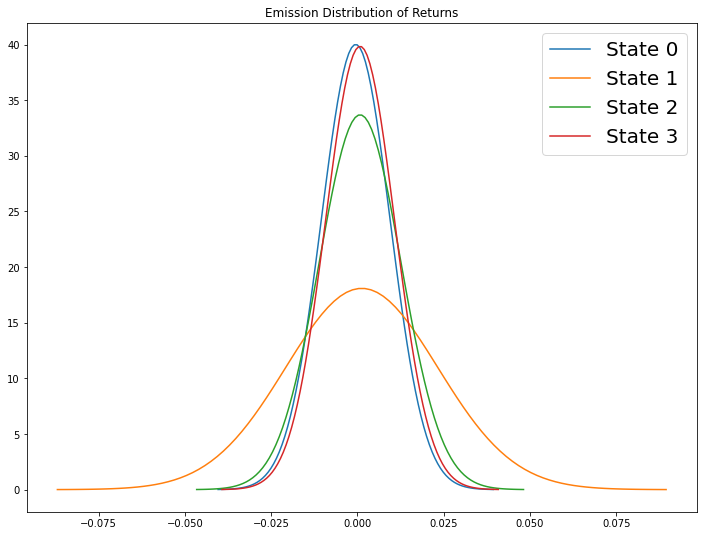

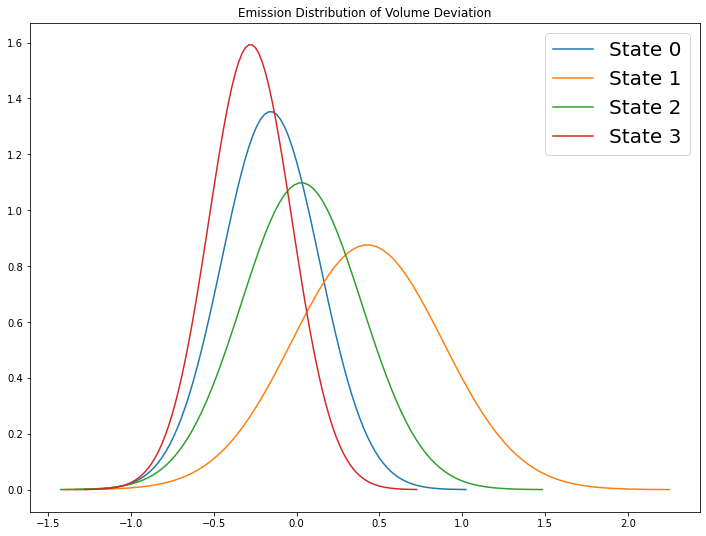

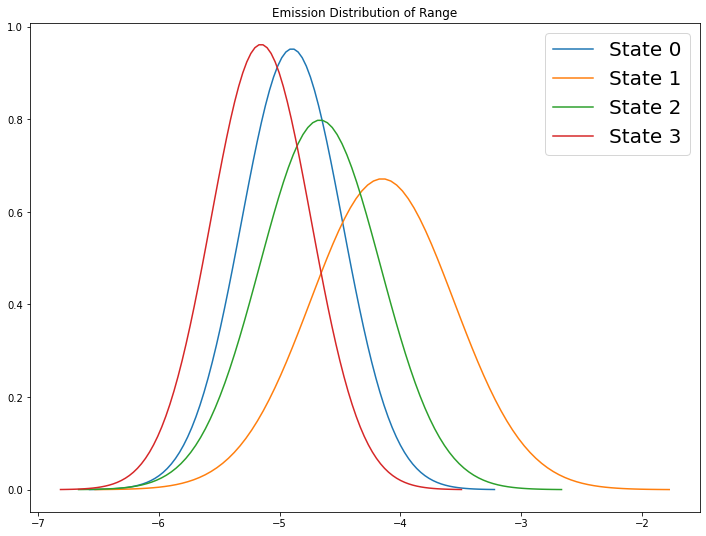

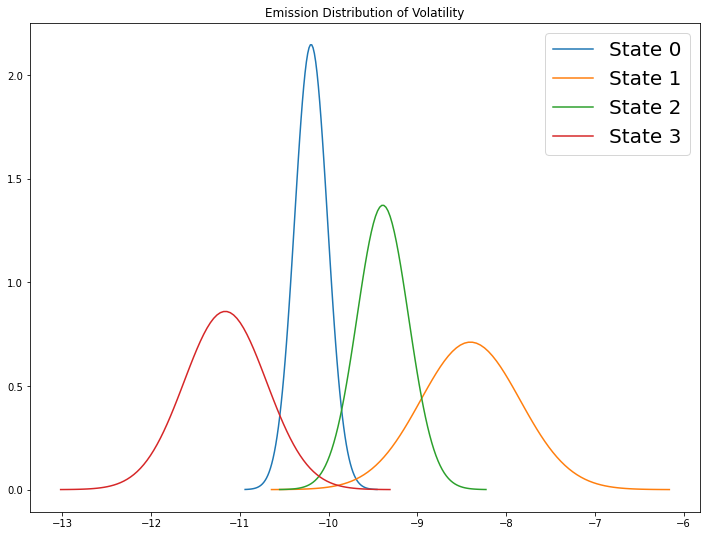

In [7]:
t.plot_comp_estimates()

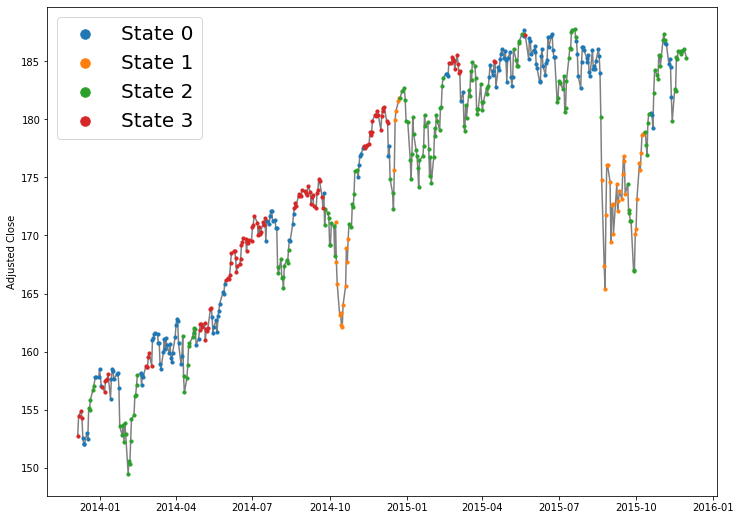

In [8]:
t.plot_states(dot_size=10)

(134.9325814887058,
           pred     left_ci    right_ci      actual
 0   153.298089  151.947061  154.649118  152.770416
 1   152.721394  151.436824  154.005964  154.477875
 2   154.544603  153.238160  155.851046  154.870636
 3   154.952951  153.641145  156.264756  154.315674
 4   154.368102  153.056339  155.679865  152.582535
 ..         ...         ...         ...         ...
 95  162.279358  159.058108  165.500609  161.942429
 96  162.455538  159.309459  165.601616  160.614670
 97  160.763127  158.974187  162.552066  161.123398
 98  161.169768  159.275000  163.064536  161.873459
 99  162.058510  160.262591  163.854428  162.356277
 
 [100 rows x 4 columns])

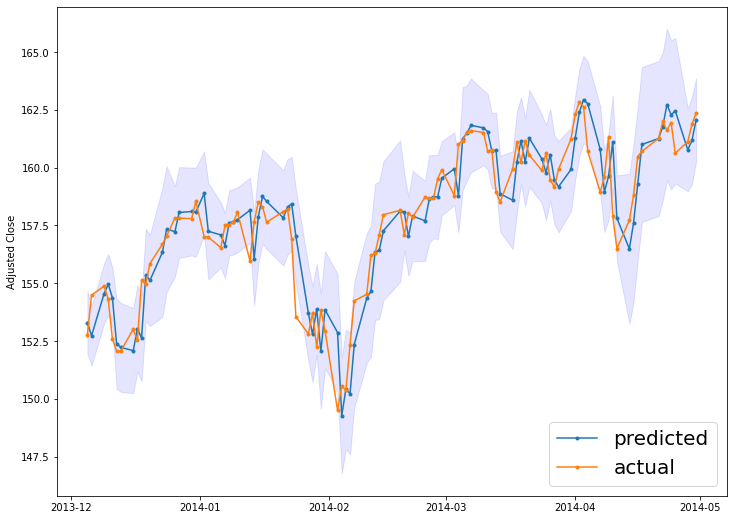

In [9]:
t.predict_next_n_days(n=100, begin_ind=5000, lag=50, show_plot=True)